> [Detrended Fluctuation Analysis in the prediction of type 2 diabetes mellitus in patients at risk: Model optimization and comparison with other metrics](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225817)


# 1. Preliminary Analysis

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import os
import re
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from pandas.plotting import scatter_matrix

## 1.1 Clinical Data

**Clininal Data Overview:**

* *pid patient id*
* *gender (0 = male, 1 = female)*
* *age (years)*
* *body mass index (Kg/m2)*
* *basal glycaemia (mg/dL)*
* *HbA1c (%)*
* *follow-up (days)*
* *final diagnosis of type 2 diabetes mellitus*

In [2]:
# Load clinical data
clinical_path = './S1/clinical_data.txt'
cols = ["pid", "gender", "age", "BMI", "glycaemia", "HbA1c", "follow.up", "T2DM"]
clinical_df = pd.read_csv(clinical_path,sep=r'\s+',engine='python',header=None,quotechar='"',skiprows=1,names=cols)
clinical_df["pid"] = clinical_df["pid"].astype(str).str.replace('"', '').astype(int)
print("\n")
print("="*100)
print(f"Clinical_data.txt imported.")

# Load each patients data
s1_folder_path = './S1'
case_csv_files = glob.glob(os.path.join(s1_folder_path, 'case*.csv'))
cnt = 0
for file_path in case_csv_files:
  # print(file_path)
  cnt += 1
print(f'Total {cnt} Patient files Loaded.')



Clinical_data.txt imported.
Total 208 Patient files Loaded.


In [3]:
# checking missing values in clinical_df
clinical_tmp = clinical_df.copy()
for col in clinical_tmp.columns:
    if clinical_tmp[col].dtype == object:
        clinical_tmp[col] = clinical_tmp[col].replace({"NA": np.nan, "na": np.nan, "Na": np.nan, "": np.nan}).where(
            clinical_tmp[col].astype(str).str.strip().ne(""), np.nan
        )

total_rows = len(clinical_tmp)
missing_count = clinical_tmp.isna().sum().rename("missing_count")
missing_pct = ((missing_count / total_rows) * 100).round(2).rename("missing_pct")
non_missing_count = (total_rows - missing_count).rename("non_missing_count")
dtypes = clinical_df.dtypes.astype(str).rename("dtype")

missing_stats = pd.concat([missing_count, missing_pct, non_missing_count, dtypes], axis=1)
print(f"Total rows: {total_rows}")
print("Missing values in clinical_df:")
display(missing_stats)

Total rows: 208
Missing values in clinical_df:


,missing_count,missing_pct,non_missing_count,dtype
pid,0,0.00,208,int64
gender,0,0.00,208,int64
age,0,0.00,208,int64
BMI,1,0.48,207,float64
glycaemia,0,0.00,208,int64
HbA1c,8,3.85,200,float64
follow.up,12,5.77,196,float64
T2DM,0,0.00,208,bool


In [4]:
clinical_df.describe()

,pid,gender,age,BMI,glycaemia,HbA1c,follow.up
count,208.000000,208.000000,208.000000,207.000000,208.000000,200.000000,196.000000
mean,105.125000,0.504808,59.600962,29.993237,100.581731,5.763500,979.831633
std,60.596103,0.501183,10.094692,4.738661,11.407814,0.295558,371.916226
min,1.000000,0.000000,29.000000,18.100000,78.000000,5.100000,176.000000
25%,52.750000,0.000000,54.000000,27.000000,92.000000,5.600000,678.500000
50%,105.500000,1.000000,61.000000,29.300000,101.000000,5.800000,992.500000
75%,157.250000,1.000000,66.000000,32.400000,108.000000,6.000000,1254.250000
max,209.000000,1.000000,88.000000,48.700000,135.000000,6.500000,2211.000000


## 1.2 Individual Patient Data

**Goal**
* Mean glucose  For each patient and for the whole dataset.
* Median glucose For each patient and for the whole dataset.
* Standard deviation:  For each patient and for the whole dataset.
* Minimum glucose: For each patient and for the whole dataset.
* Maximum glucose: For each patient and for the whole dataset.
* Range = max – min :For each patient and for the whole dataset.
* Coefficient of variation (CV) = SD / Mean : For each patient and for the whole dataset.
* percentage of readings <70 mg/dL  only for each patient.
* Percentage of readings between 70–170 mg/dL  only for each patient
* Percentage  of readings >170 mg/dL  only for each patient.


In [5]:
# Compute the Overall descriptive statistics for the 'glucemia' column across all loaded DataFrames.
all_glucemia_data = pd.concat([pd.read_csv(file_path)['glucemia'] for file_path in case_csv_files])

overall_mean_glucose = all_glucemia_data.mean()
overall_median_glucose = all_glucemia_data.median()
overall_std_glucose = all_glucemia_data.std()
overall_min_glucose = all_glucemia_data.min()
overall_max_glucose = all_glucemia_data.max()
overall_range_glucose = overall_max_glucose - overall_min_glucose
overall_cv_glucose = (overall_std_glucose / overall_mean_glucose) if overall_mean_glucose != 0 else np.nan

overall_stats = {
    'mean': overall_mean_glucose,
    'median': overall_median_glucose,
    'std': overall_std_glucose,
    'min': overall_min_glucose,
    'max': overall_max_glucose,
    'range': overall_range_glucose,
    'cv': overall_cv_glucose,
}

In [6]:
# Calculated descriptive statistics for each patient and for the whole dataset.
case_stats_list = []

cnt = 0
for file_path in case_csv_files:
    cnt += 1
    df_case = pd.read_csv(file_path)
    glucemia_data = df_case['glucemia']

    mean_glucose = glucemia_data.mean()
    median_glucose = glucemia_data.median()
    std_glucose = glucemia_data.std()
    min_glucose = glucemia_data.min()
    max_glucose = glucemia_data.max()
    range_glucose = max_glucose - min_glucose
    cv_glucose = (std_glucose / mean_glucose) if mean_glucose != 0 else np.nan

    percent_lt_70 = (glucemia_data < 70).mean() * 100
    percent_70_170 = ((glucemia_data >= 70) & (glucemia_data <= 170)).mean() * 100
    percent_gt_170 = (glucemia_data > 170).mean() * 100

    case_stats = {
        'file_name': os.path.basename(file_path),
        'mean': mean_glucose,
        'median': median_glucose,
        'std': std_glucose,
        'min': min_glucose,
        'max': max_glucose,
        'range': range_glucose,
        'cv': cv_glucose,
        '% < 70': percent_lt_70,
        '% 70-170': percent_70_170,
        '% > 170': percent_gt_170,
    }
    case_stats_list.append(case_stats)

case_stats_df = pd.DataFrame(case_stats_list)
print(f"Total {cnt} Patient files Loaded.")

Total 208 Patient files Loaded.


In [7]:
# Display the calculated descriptive statistics for each patient and for the whole dataset.
print('\033[1m' + "\nOverall Descriptive Statistics for Glucose Levels:" + '\033[0m', "\n")
display(pd.DataFrame([overall_stats]))
print("-"*100,"\n")
print('\033[1m' +  "Descriptive Statistics for Each Patient:" + '\033[0m')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(case_stats_df.head())


Overall Descriptive Statistics for Glucose Levels: 



,mean,median,std,min,max,range,cv
0,102.320342,100.0,21.805964,40.0,318.0,278.0,0.213115


---------------------------------------------------------------------------------------------------- 

Descriptive Statistics for Each Patient:


,file_name,mean,median,std,min,max,range,cv,% < 70,% 70-170,% > 170
0,case 142.csv,115.355903,109.0,19.627932,86.0,170.0,84.0,0.170151,0.000000,100.000000,0.000000
1,case 156.csv,158.125000,153.0,31.629568,84.0,222.0,138.0,0.200029,0.000000,61.805556,38.194444
2,case 181.csv,97.206597,97.0,7.316261,81.0,116.0,35.0,0.075265,0.000000,100.000000,0.000000
3,case 195.csv,84.230903,87.0,13.160831,51.0,116.0,65.0,0.156247,13.888889,86.111111,0.000000
4,case 59.csv,112.491950,111.0,16.050643,84.0,164.0,80.0,0.142683,0.000000,97.048611,0.000000


# 2. Data Visualization

Generate plots to visualize the distribution of descriptive statistics across patients.

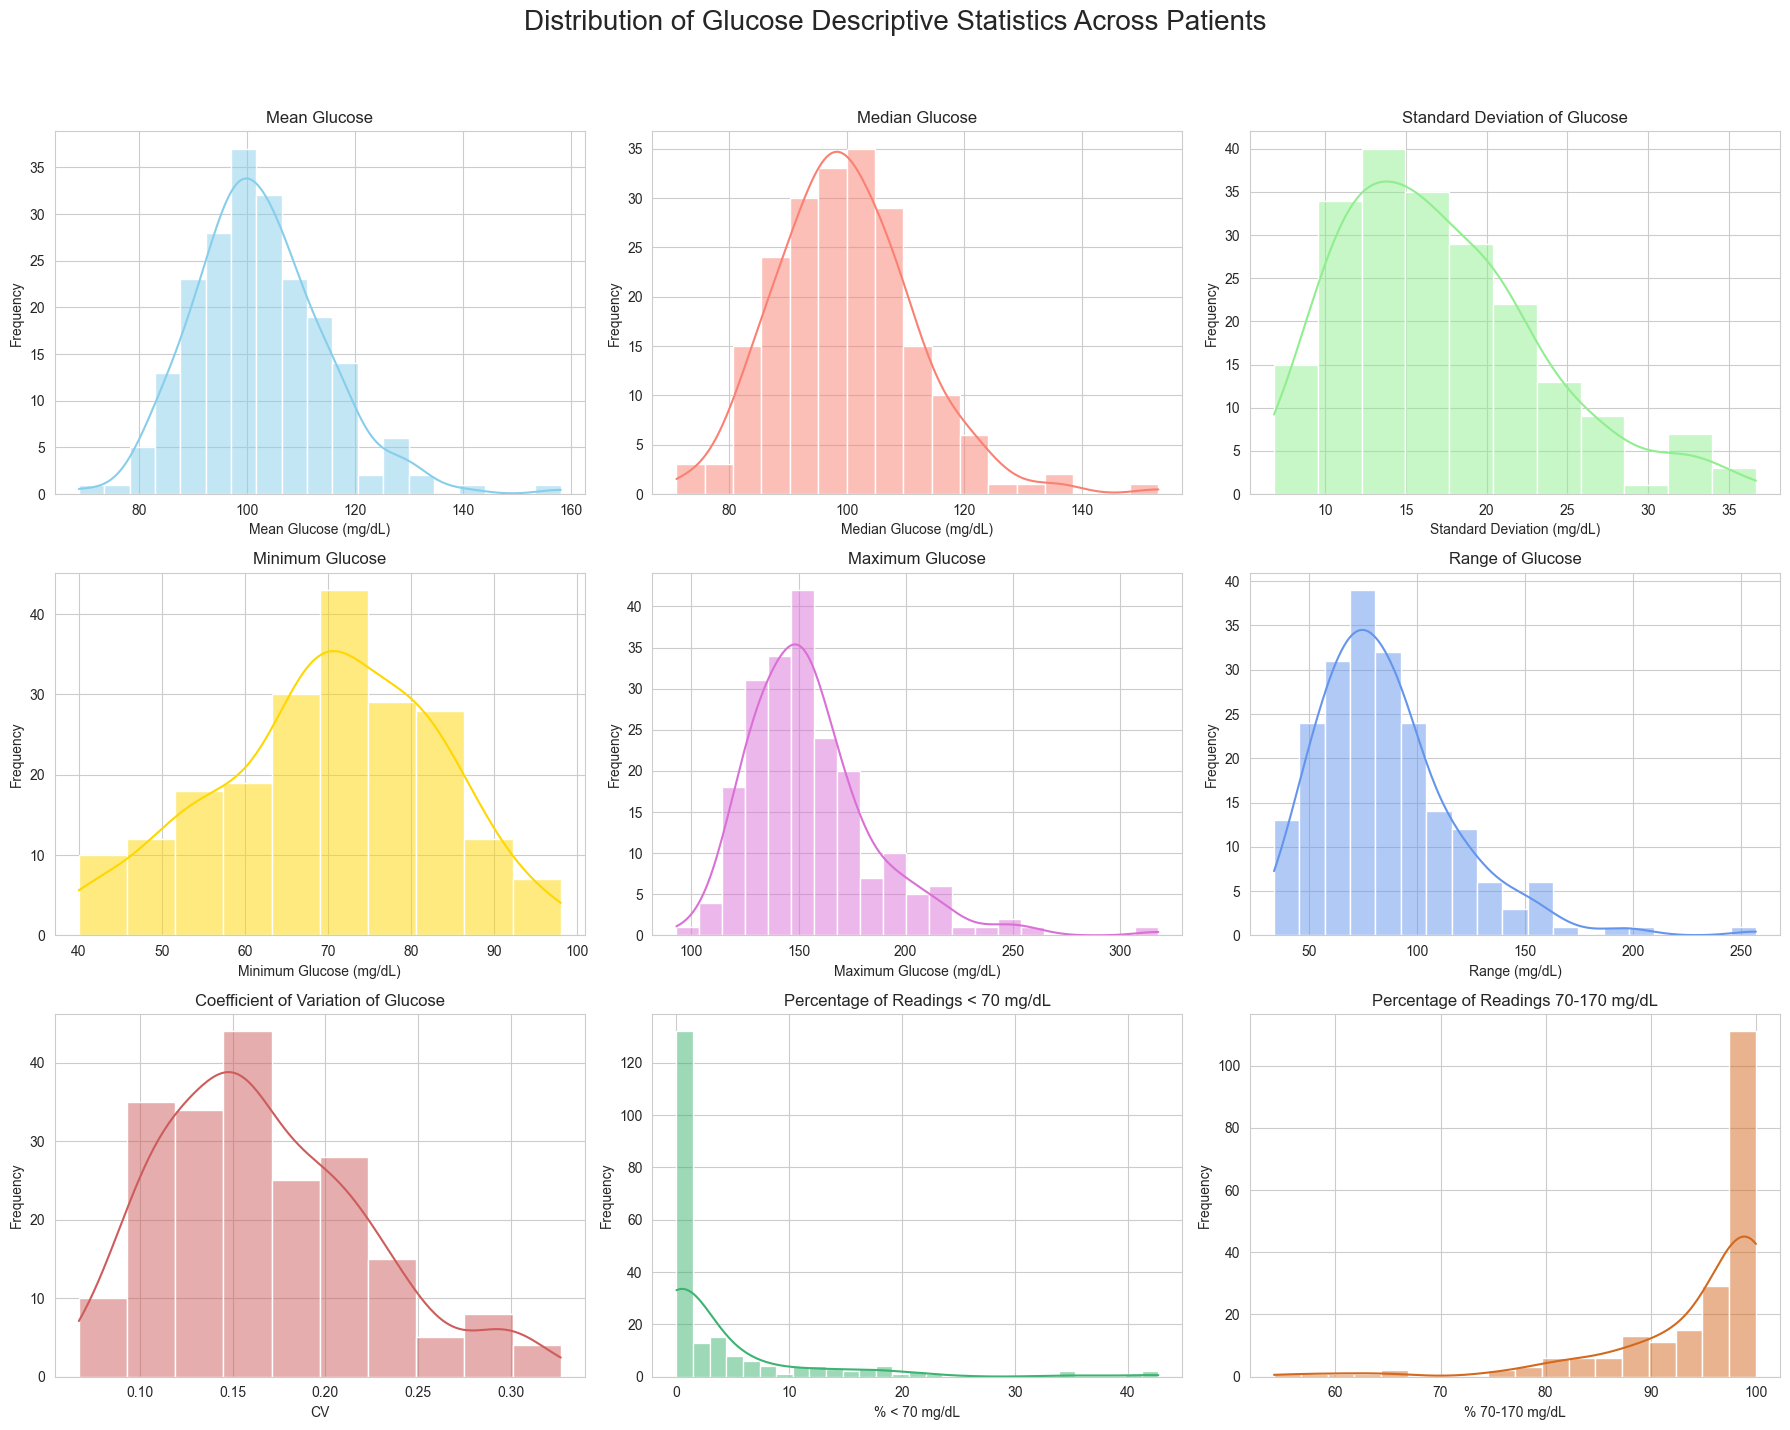

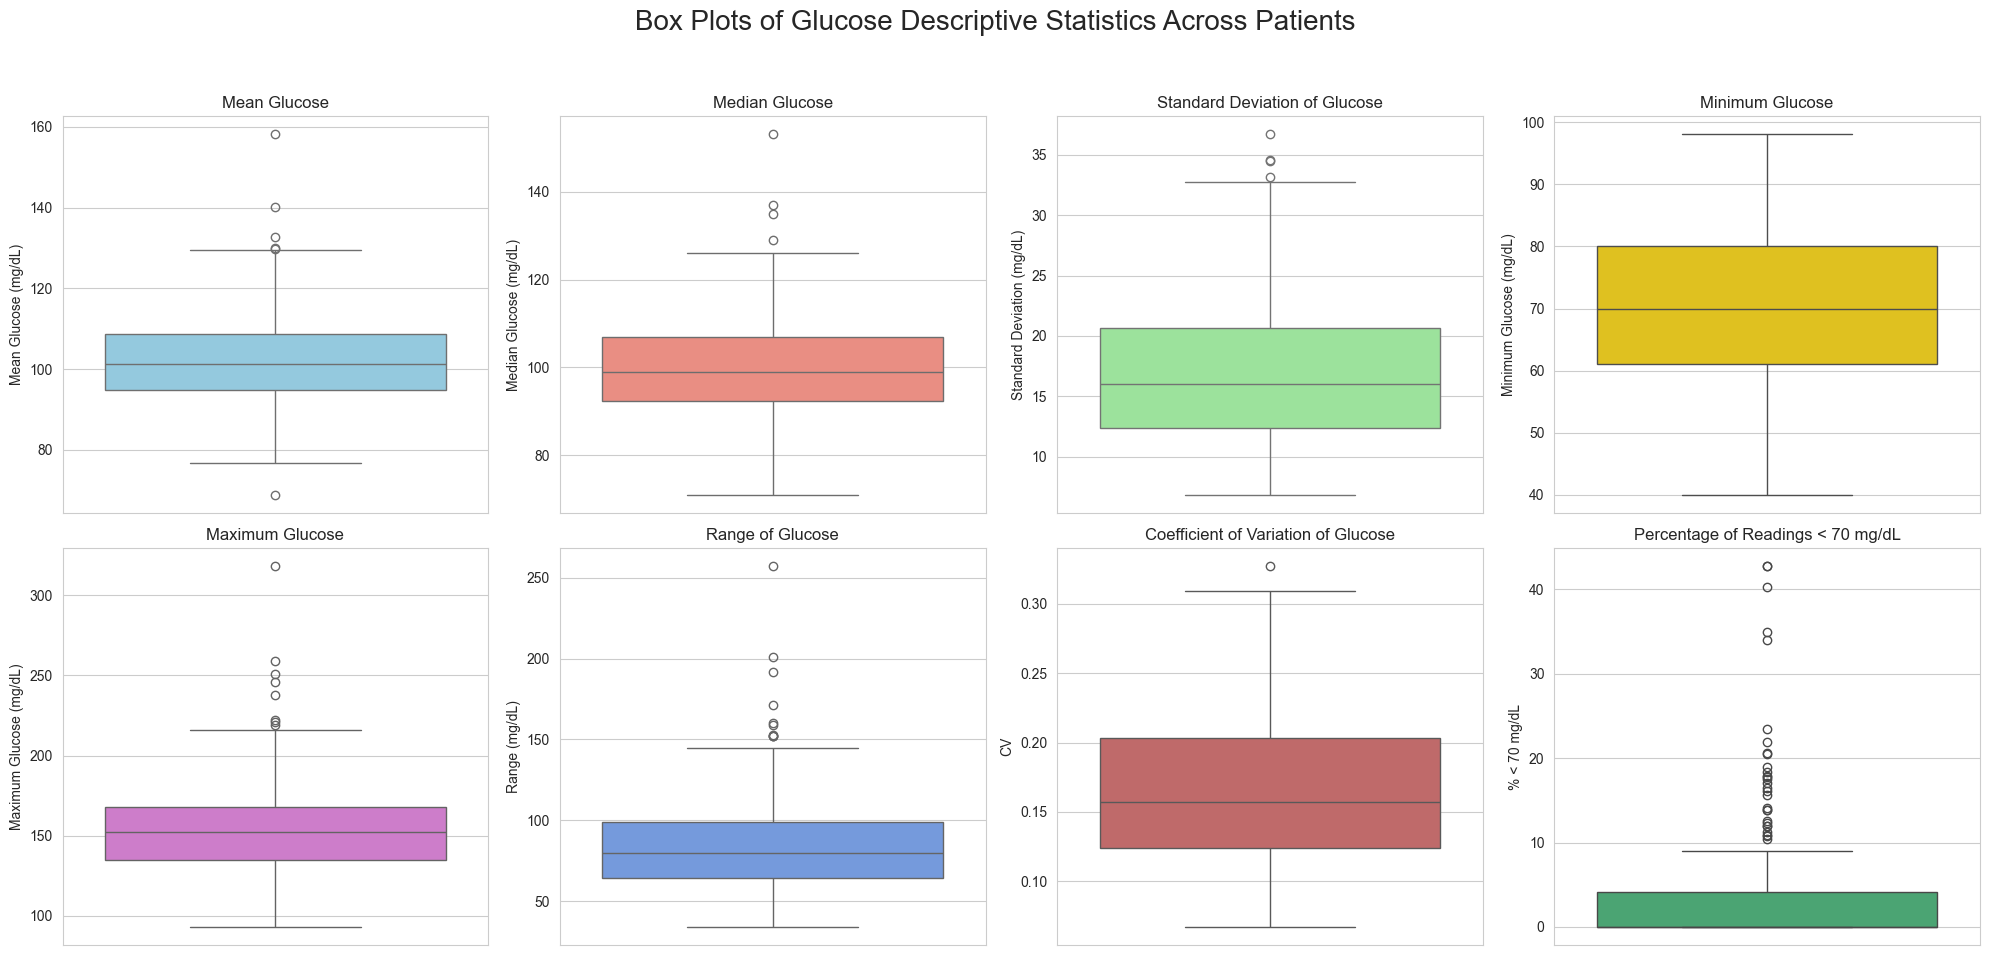

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create histograms for key statistics
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Distribution of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.histplot(case_stats_df['mean'], ax=axes[0, 0], kde=True, color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_xlabel('Mean Glucose (mg/dL)')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['median'], ax=axes[0, 1], kde=True, color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_xlabel('Median Glucose (mg/dL)')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['std'], ax=axes[0, 2], kde=True, color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_xlabel('Standard Deviation (mg/dL)')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['min'], ax=axes[1, 0], kde=True, color='gold')
axes[1, 0].set_title('Minimum Glucose')
axes[1, 0].set_xlabel('Minimum Glucose (mg/dL)')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['max'], ax=axes[1, 1], kde=True, color='orchid')
axes[1, 1].set_title('Maximum Glucose')
axes[1, 1].set_xlabel('Maximum Glucose (mg/dL)')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['range'], ax=axes[1, 2], kde=True, color='cornflowerblue')
axes[1, 2].set_title('Range of Glucose')
axes[1, 2].set_xlabel('Range (mg/dL)')
axes[1, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['cv'], ax=axes[2, 0], kde=True, color='indianred')
axes[2, 0].set_title('Coefficient of Variation of Glucose')
axes[2, 0].set_xlabel('CV')
axes[2, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['% < 70'], ax=axes[2, 1], kde=True, color='mediumseagreen')
axes[2, 1].set_title('Percentage of Readings < 70 mg/dL')
axes[2, 1].set_xlabel('% < 70 mg/dL')
axes[2, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['% 70-170'], ax=axes[2, 2], kde=True, color='chocolate')
axes[2, 2].set_title('Percentage of Readings 70-170 mg/dL')
axes[2, 2].set_xlabel('% 70-170 mg/dL')
axes[2, 2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# You can also create box plots to see the distribution and outliers
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Box Plots of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.boxplot(y=case_stats_df['mean'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_ylabel('Mean Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['median'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_ylabel('Median Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['std'], ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_ylabel('Standard Deviation (mg/dL)')

sns.boxplot(y=case_stats_df['min'], ax=axes[0, 3], color='gold')
axes[0, 3].set_title('Minimum Glucose')
axes[0, 3].set_ylabel('Minimum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['max'], ax=axes[1, 0], color='orchid')
axes[1, 0].set_title('Maximum Glucose')
axes[1, 0].set_ylabel('Maximum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['range'], ax=axes[1, 1], color='cornflowerblue')
axes[1, 1].set_title('Range of Glucose')
axes[1, 1].set_ylabel('Range (mg/dL)')

sns.boxplot(y=case_stats_df['cv'], ax=axes[1, 2], color='indianred')
axes[1, 2].set_title('Coefficient of Variation of Glucose')
axes[1, 2].set_ylabel('CV')

sns.boxplot(y=case_stats_df['% < 70'], ax=axes[1, 3], color='mediumseagreen')
axes[1, 3].set_title('Percentage of Readings < 70 mg/dL')
axes[1, 3].set_ylabel('% < 70 mg/dL')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 2.1 Missing Values Check

In [9]:
# Check missing values in clinical data
clinical_missing_values = clinical_df.isnull().sum()
print("Missing values in clinical_df:")
print(clinical_missing_values)

# Check missing values in individual patient glucose data
case_glucemia_missing_values = {}
for file_path in case_csv_files:
    df_case = pd.read_csv(file_path)
    missing_count = df_case['glucemia'].isnull().sum()
    case_glucemia_missing_values[os.path.basename(file_path)] = missing_count

print("\nMissing values in 'glucemia' column for each patient file:")
for file_name, count in case_glucemia_missing_values.items():
    if count > 0:
        print(f"{file_name}: {count}")

Missing values in clinical_df:
pid           0
gender        0
age           0
BMI           1
glycaemia     0
HbA1c         8
follow.up    12
T2DM          0
dtype: int64

Missing values in 'glucemia' column for each patient file:
case  59.csv: 17
case  9.csv: 17
case  70.csv: 9
case  141.csv: 43
case  73.csv: 17
case  197.csv: 8
case  150.csv: 48
case  184.csv: 20
case  191.csv: 9
case  132.csv: 8
case  130.csv: 3
case  118.csv: 17
case  24.csv: 59
case  30.csv: 8
case  19.csv: 9
case  112.csv: 17
case  20.csv: 8
case  111.csv: 17
case  104.csv: 20
case  201.csv: 38
case  1.csv: 9
case  148.csv: 50
case  159.csv: 26
case  207.csv: 33
case  6.csv: 30
case  80.csv: 10
case  43.csv: 9
case  158.csv: 20
case  164.csv: 17
case  41.csv: 9
case  204.csv: 20
case  205.csv: 17
case  4.csv: 8
case  68.csv: 9


# 3. Preprocessing 
Preprocess raw data with missing values/records using two 2 approach


**Approach 1:**

- Make a copy of your current code and dataframe.
- Drop the case 79, 209, and all the patients whom HbA1c is missing.
- Take the max of "follow up" and use that value to impute the missing values.
- Fill the row where BMI is missing with :29.3. I got this value from their paper. 

**Approach 2:**

- Make a copy of your current code and dataframe.
- Drop the case 79, 209.
- Fill out and the rows with missing HbA1c with this value: 5.8, per their paper.
- Fill the missing "follow up" with 3 months (90 days).
- Fill the row where BMI is missing with this value:29.3, per their paper. 

## 3.1 Approach 1

In [10]:
# 1. CONFIGURATION
input_dir = "S1"
base_dir_a1 = "S1_approach1"   # new experiment folder
os.makedirs(base_dir_a1, exist_ok=True)

# define subdirectories under experiment folder
backup_dir = os.path.join(base_dir_a1, "S1_backup")
imputed_dir = os.path.join(base_dir_a1, "S1_perm")

# 2. BACKUP ORIGINAL DATA
if not os.path.exists(backup_dir):
    shutil.copytree(input_dir, backup_dir)
    print(f"Backup created: {backup_dir}")
else:
    print(f"Backup already exists: {backup_dir}")

# 3. DEFINE IMPUTATION FUNCTION
def impute_mean_of_neighbors(series):
    """Impute missing values using mean of previous two and next two non-NaN values."""
    s = pd.Series(series).copy()
    n = len(s)
    for i in range(n):
        if pd.isna(s.iloc[i]):
            prev_vals, next_vals = [], []

            # Look backward for up to 2 non-NaN values
            j = i - 1
            while j >= 0 and len(prev_vals) < 2:
                if not pd.isna(s.iloc[j]):
                    prev_vals.append(s.iloc[j])
                j -= 1

            # Look forward for up to 2 non-NaN values
            j = i + 1
            while j < n and len(next_vals) < 2:
                if not pd.isna(s.iloc[j]):
                    next_vals.append(s.iloc[j])
                j += 1

            neighbor_vals = prev_vals + next_vals
            if neighbor_vals:
                s.iloc[i] = np.mean(neighbor_vals)
    return s

# 4. IMPUTE CASE FILES
os.makedirs(imputed_dir, exist_ok=True)
case_paths = sorted(glob.glob(os.path.join(input_dir, "case*.csv")))
print(f"Found {len(case_paths)} case files in {input_dir}/")

for path in case_paths:
    df = pd.read_csv(path)
    if "glucemia" not in df.columns:
        print(f"Skipping {path} (no 'glucemia' column)")
        continue

    df["glucemia"] = pd.to_numeric(df["glucemia"], errors="coerce")
    imputed = impute_mean_of_neighbors(df["glucemia"])
    mask = df["glucemia"].isna()
    df.loc[mask, "glucemia"] = imputed[mask]

    base = os.path.basename(path)
    out_path = os.path.join(imputed_dir, base)
    df.to_csv(out_path, index=False, quoting=1)
    print(f" Imputed and wrote {out_path}")

# 5. LOAD & CLEAN CLINICAL DATA
clinical_columns = ["patient_id","gender","age","BMI","glycaemia","HbA1c","follow_up","T2DM"]
clinical_path_a1 = os.path.join(input_dir, "clinical_data.txt")

clinical_df_a1 = pd.read_csv(
    clinical_path_a1,
    sep=r"\s+",
    quotechar='"',
    engine="python",
    names=clinical_columns,
    skiprows=1,
)

# Clean patient_id (remove quotes etc.)
clinical_df_a1["patient_id"] = (
    clinical_df_a1["patient_id"]
    .astype(str)
    .str.strip()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
    .astype(int)
)

# Clean numeric columns
for col in ["BMI", "HbA1c", "follow_up"]:
    clinical_df_a1[col] = (
        clinical_df_a1[col]
        .replace({"NA": np.nan, "na": np.nan, "Na": np.nan})
        .apply(lambda x: np.nan if (isinstance(x, str) and x.strip() == "") else x)
    )
    clinical_df_a1[col] = pd.to_numeric(clinical_df_a1[col], errors="coerce")

# Drop rules
clinical_df_a1 = clinical_df_a1[~clinical_df_a1["patient_id"].isin([79, 209])]
clinical_df_a1 = clinical_df_a1[clinical_df_a1["HbA1c"].notna()]

# Impute missing follow_up with max
if clinical_df_a1["follow_up"].notna().any():
    max_follow = clinical_df_a1["follow_up"].max()
    clinical_df_a1["follow_up"] = clinical_df_a1["follow_up"].fillna(max_follow)

# Fill missing BMI with 29.3
clinical_df_a1["BMI"] = clinical_df_a1["BMI"].fillna(29.3)

# Normalize T2DM column
if clinical_df_a1["T2DM"].dtype == object:
    clinical_df_a1["T2DM"] = (
        clinical_df_a1["T2DM"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"TRUE": True, "FALSE": False})
    )

# Save cleaned clinical
cleaned_path_a1 = os.path.join(base_dir_a1, "clinical_data_cleaned_a1.txt")
clinical_df_a1.to_csv(cleaned_path_a1, sep=" ", index=False)
print(f"🧼 Cleaned clinical saved: {cleaned_path_a1}")

# 6. MERGE IMPUTED CASES WITH CLEANED CLINICAL
allowed_ids_a1 = set(clinical_df_a1["patient_id"].astype(int))
case_files_a1 = sorted(glob.glob(os.path.join(imputed_dir, "case*.csv")))

case_frames_a1 = []
for fp in case_files_a1:
    fn = os.path.basename(fp)
    m = re.search(r"(\d+)", fn)
    if not m:
        continue
    pid = int(m.group(1))
    if pid not in allowed_ids_a1:
        continue
    df_case = pd.read_csv(fp)
    df_case["patient_id"] = pid
    df_case["source_file"] = fn
    case_frames_a1.append(df_case)

cases_df_a1 = pd.concat(case_frames_a1, ignore_index=True) if case_frames_a1 else pd.DataFrame()

merged_df_a1 = cases_df_a1.merge(clinical_df_a1, on="patient_id", how="left")

# 7. FIX patient_id FIELD IF NEEDED
merged_df_a1["patient_id"] = (
    merged_df_a1["patient_id"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(float)
    .astype("Int64")
)

# 8. SAVE MERGED DATA
merged_path_a1 = os.path.join(base_dir_a1, "merged_cases_with_clinical_a1_fixed.csv")
merged_df_a1.to_csv(merged_path_a1, index=False)
print(f"Final merged data saved: {merged_path_a1}")

# 9. SUMMARY
print(
    f"\nSummary:\n"
    f"  - Experiment folder: {base_dir_a1}\n"
    f"  - Patients kept: {len(allowed_ids_a1)}\n"
    f"  - Case rows: {len(cases_df_a1):,}\n"
    f"  - Merged rows: {len(merged_df_a1):,}\n"
)


Backup already exists: S1_approach1/S1_backup
Found 208 case files in S1/
 Imputed and wrote S1_approach1/S1_perm/case  1.csv
 Imputed and wrote S1_approach1/S1_perm/case  10.csv
 Imputed and wrote S1_approach1/S1_perm/case  100.csv
 Imputed and wrote S1_approach1/S1_perm/case  101.csv
 Imputed and wrote S1_approach1/S1_perm/case  102.csv
 Imputed and wrote S1_approach1/S1_perm/case  103.csv
 Imputed and wrote S1_approach1/S1_perm/case  104.csv
 Imputed and wrote S1_approach1/S1_perm/case  105.csv
 Imputed and wrote S1_approach1/S1_perm/case  106.csv
 Imputed and wrote S1_approach1/S1_perm/case  107.csv
 Imputed and wrote S1_approach1/S1_perm/case  108.csv
 Imputed and wrote S1_approach1/S1_perm/case  109.csv
 Imputed and wrote S1_approach1/S1_perm/case  11.csv
 Imputed and wrote S1_approach1/S1_perm/case  110.csv
 Imputed and wrote S1_approach1/S1_perm/case  111.csv
 Imputed and wrote S1_approach1/S1_perm/case  112.csv
 Imputed and wrote S1_approach1/S1_perm/case  113.csv
 Imputed and

Reading case files from: S1_approach1/S1_perm...
Found 208 files. Processing...

✅ Computed statistics for 208 patients.
Loading clinical data from: S1_approach1/clinical_data_cleaned_a1.txt...
Merged Data Shape: (199, 14)
----------------------------------------
FINAL PREVIEW:
   patient_id  gender  age   BMI  glyceamia  HbA1c    BGL mean    BGL std  \
0           1       1   77  25.4        106    6.3   98.518170  19.581356   
1          10       1   70  33.3         98    5.5   85.092014  16.020863   
2         101       1   63  26.5         97    5.8   94.039931   6.835722   
3         102       1   45  30.7        110    6.0  117.111111  11.565082   
4         103       0   55  32.4         90    5.7  115.107639  32.755041   

         CV  %time < 70  %time 70-140  %time > 140   T2DM  
0  0.198759    0.173611     96.701389     3.125000  False  
1  0.188277   18.402778     81.597222     0.000000  False  
2  0.072690    0.000000    100.000000     0.000000  False  
3  0.098753    0.0

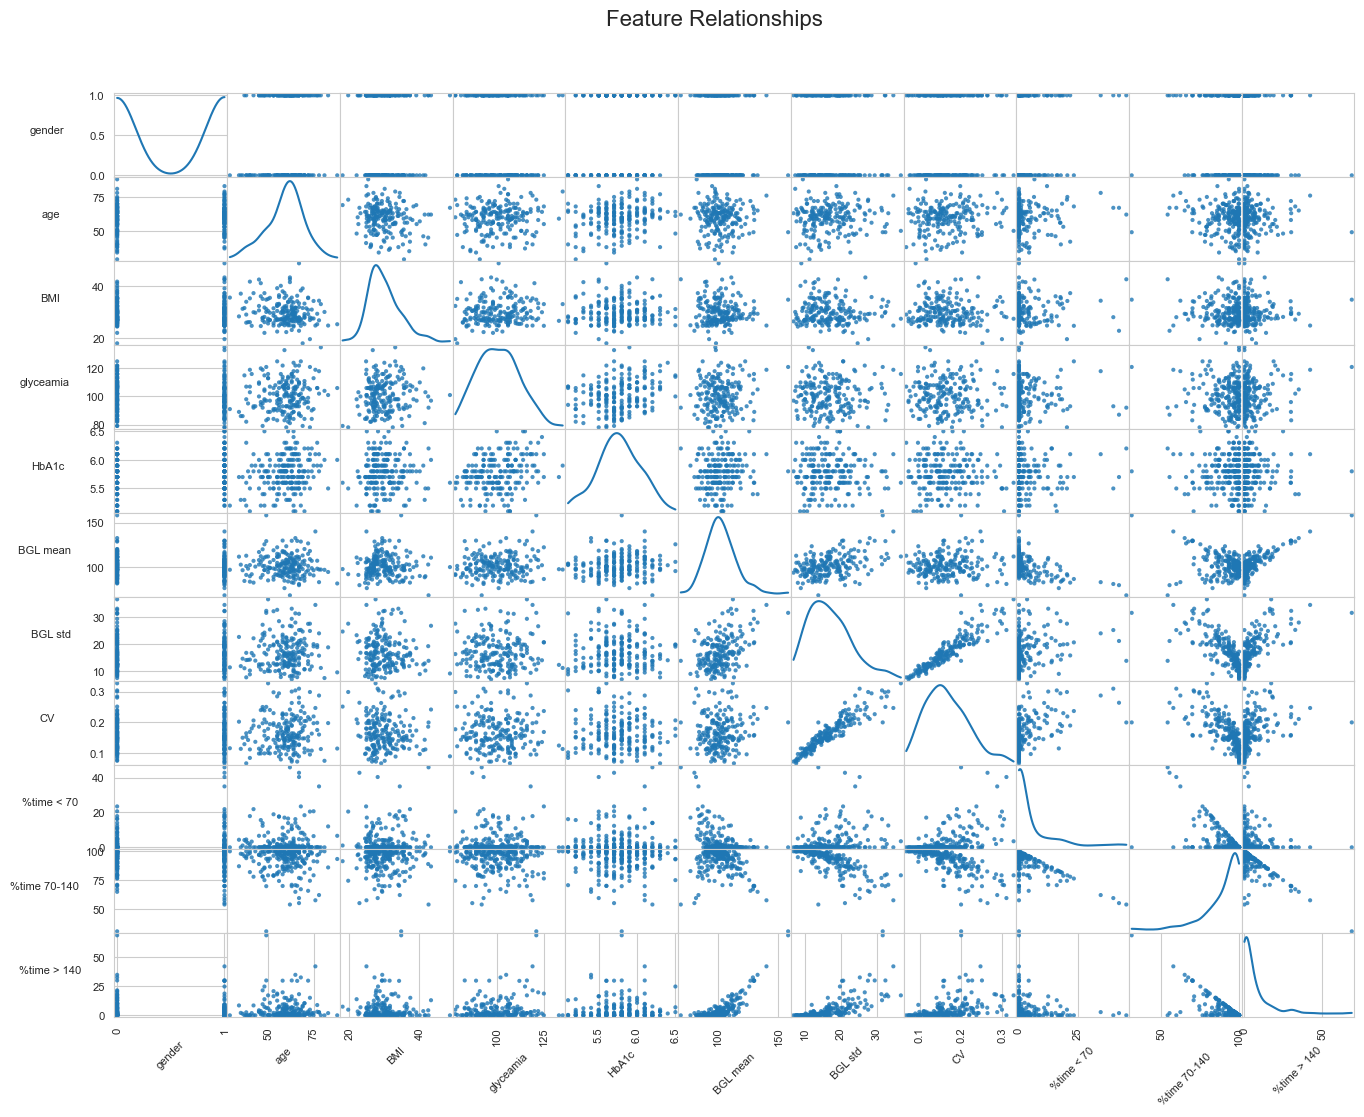

In [13]:
# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
BASE_DIR = "S1_approach1"
IMPUTED_DIR = os.path.join(BASE_DIR, "S1_perm")
CLINICAL_FILE = os.path.join(BASE_DIR, "clinical_data_cleaned_a1.txt")
OUTPUT_FILE = os.path.join(BASE_DIR, "final_dataset_for_modeling.csv")

FINAL_COLUMNS = [
    "patient_id", 
    "gender", "age", "BMI", "glyceamia", "HbA1c", 
    "BGL mean", "BGL std", "CV", "%time < 70", "%time 70-140", "%time > 140", 
    "T2DM" 
]

# ---------------------------------------------------------
# 2. CALCULATE CGM STATISTICS
# ---------------------------------------------------------
print(f"Reading case files from: {IMPUTED_DIR}...")

# Find all csv files
case_files = sorted(glob.glob(os.path.join(IMPUTED_DIR, "*.csv")))

if not case_files:
    print(f"❌ Error: No CSV files found in {IMPUTED_DIR}")
    print("Please ensure the previous data processing step ran correctly.")
    exit()

print(f"Found {len(case_files)} files. Processing...")

case_stats_list = []

for file_path in case_files:
    filename = os.path.basename(file_path)
    
    # ROBUST ID EXTRACTION:
    # Look for the first sequence of digits in the filename
    match = re.search(r"(\d+)", filename)
    
    if not match:
        print(f"   ⚠️ Skipping {filename}: Could not extract Patient ID (no numbers found).")
        continue
        
    patient_id = int(match.group(1))

    # Read Data
    try:
        df_case = pd.read_csv(file_path)
    except Exception as e:
        print(f"   ⚠️ Error reading {filename}: {e}")
        continue
    
    # Check for glucose column (handle variations in naming)
    col_map = {c.lower(): c for c in df_case.columns}
    if 'glucemia' in col_map:
        gluc_col = col_map['glucemia']
    elif 'glucose' in col_map:
        gluc_col = col_map['glucose']
    else:
        print(f"   ⚠️ Skipping {filename}: No 'glucemia' or 'glucose' column found.")
        continue
        
    glucemia_data = df_case[gluc_col]

    # --- STATISTICS ---
    mean_glucose = glucemia_data.mean()
    std_glucose = glucemia_data.std()
    cv_glucose = (std_glucose / mean_glucose) if mean_glucose != 0 else np.nan

    # Time in Ranges (70-140)
    percent_lt_70 = (glucemia_data < 70).mean() * 100
    percent_70_140 = ((glucemia_data >= 70) & (glucemia_data <= 140)).mean() * 100
    percent_gt_140 = (glucemia_data > 140).mean() * 100

    case_stats = {
        'patient_id': patient_id,
        'BGL mean': mean_glucose,
        'BGL std': std_glucose,
        'CV': cv_glucose,
        '%time < 70': percent_lt_70,
        '%time 70-140': percent_70_140,
        '%time > 140': percent_gt_140
    }
    case_stats_list.append(case_stats)

# Convert to DataFrame
if not case_stats_list:
    print("\n❌ CRITICAL ERROR: No patients were processed successfully.")
    print("Check your input files and column names.")
    exit()

stats_df = pd.DataFrame(case_stats_list)
print(f"\n✅ Computed statistics for {len(stats_df)} patients.")


# ---------------------------------------------------------
# 3. LOAD & MERGE CLINICAL DATA
# ---------------------------------------------------------
print(f"Loading clinical data from: {CLINICAL_FILE}...")

if not os.path.exists(CLINICAL_FILE):
    print(f"Error: Clinical file not found at {CLINICAL_FILE}")
    exit()

# Load cleaned clinical data (space-separated based on previous steps)
clinical_df = pd.read_csv(CLINICAL_FILE, sep=" ")

# Merge
# Inner join: Drops patients who have CGM data but no Clinical data (or vice versa)
final_df = pd.merge(stats_df, clinical_df, on="patient_id", how="inner")

print(f"Merged Data Shape: {final_df.shape}")

if final_df.empty:
    print("❌ Error: Merged dataset is empty!")
    print("Possible reason: Patient IDs in filenames don't match Patient IDs in clinical file.")
    print(f"Sample File IDs: {stats_df['patient_id'].head().tolist()}")
    print(f"Sample Clinical IDs: {clinical_df['patient_id'].head().tolist()}")
    exit()

# ---------------------------------------------------------
# 4. CLEANUP & FORMATTING
# ---------------------------------------------------------

# Handle spelling variations
if 'glycaemia' in final_df.columns:
    final_df.rename(columns={'glycaemia': 'glyceamia'}, inplace=True)

# Filter to requested columns
# Use 'interesection' to avoid KeyError if a column is missing
available_columns = [c for c in FINAL_COLUMNS if c in final_df.columns]
final_df = final_df[available_columns]

# Fill NaNs
final_df = final_df.fillna(final_df.median(numeric_only=True))

# Save
final_df.to_csv(OUTPUT_FILE, index=False)
print("-" * 40)
print("FINAL PREVIEW:")
print(final_df.head())
print("-" * 40)
print(f"✅ Success! Final dataset saved to: {OUTPUT_FILE}")


# ---------------------------------------------------------
# 5. SCATTER MATRIX
# ---------------------------------------------------------
print("\nGenerating Scatter Matrix...")
plot_cols = [c for c in final_df.columns if c not in ['patient_id', 'T2DM']]

try:
    sm = scatter_matrix(final_df[plot_cols], figsize=(16, 12), alpha=0.8, diagonal='kde')
    for ax in sm.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=45)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8, rotation=0, labelpad=30)
    plt.suptitle("Feature Relationships", y=0.95, fontsize=16)
    plt.show()
except Exception as e:
    print(f"Could not generate plot: {e}")

## 3.2 Approach 2

S1_approach2 already exists — skipping copy.
Cleaned clinical saved → S1_approach2/clinical_data_cleaned_a2.txt
Found 208 case files in S1_approach2/
Imputed glucemia → case  1.csv
Imputed glucemia → case  10.csv
Imputed glucemia → case  100.csv
Imputed glucemia → case  101.csv
Imputed glucemia → case  102.csv
Imputed glucemia → case  103.csv
Imputed glucemia → case  104.csv
Imputed glucemia → case  105.csv
Imputed glucemia → case  106.csv
Imputed glucemia → case  107.csv
Imputed glucemia → case  108.csv
Imputed glucemia → case  109.csv
Imputed glucemia → case  11.csv
Imputed glucemia → case  110.csv
Imputed glucemia → case  111.csv
Imputed glucemia → case  112.csv
Imputed glucemia → case  113.csv
Imputed glucemia → case  114.csv
Imputed glucemia → case  115.csv
Imputed glucemia → case  116.csv
Imputed glucemia → case  117.csv
Imputed glucemia → case  118.csv
Imputed glucemia → case  119.csv
Imputed glucemia → case  12.csv
Imputed glucemia → case  120.csv
Imputed glucemia → case  121.c

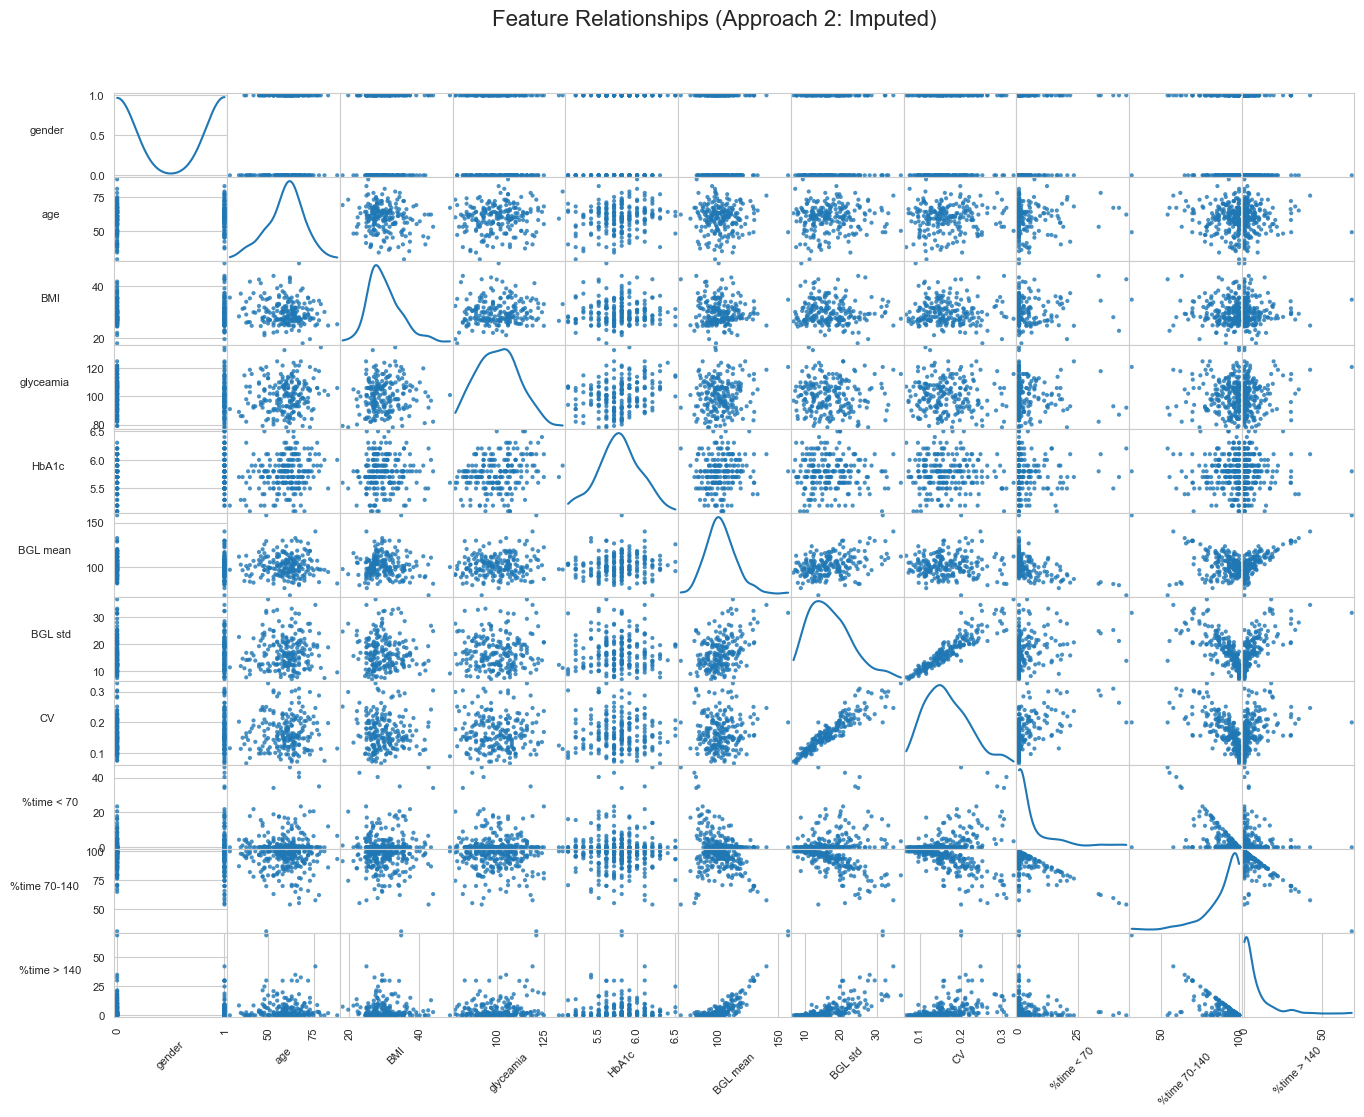

Scatter matrix displayed.


In [14]:
# Setup new experiment folder
src_dir = "S1"
base_dir_a2 = "S1_approach2"

if os.path.exists(base_dir_a2):
    print(f"{base_dir_a2} already exists — skipping copy.")
else:
    shutil.copytree(src_dir, base_dir_a2)
    print(f"Copied {src_dir}/ → {base_dir_a2}/")

# Define helper for glucemia imputation
def impute_mean_of_neighbors(series):
    """Impute missing values using mean of previous two and next two non-NaN values."""
    s = series.copy()
    n = len(s)
    for i in range(n):
        if pd.isna(s[i]):
            prev_vals, next_vals = [], []
            j = i - 1
            while j >= 0 and len(prev_vals) < 2:
                if not pd.isna(s[j]):
                    prev_vals.append(s[j])
                j -= 1
            j = i + 1
            while j < n and len(next_vals) < 2:
                if not pd.isna(s[j]):
                    next_vals.append(s[j])
                j += 1
            neighbor_vals = prev_vals + next_vals
            if neighbor_vals:
                s[i] = np.mean(neighbor_vals)
    return s

# Clinical data cleaning
clinical_columns = ["patient_id","gender","age","BMI","glycaemia","HbA1c","follow_up","T2DM"]
clinical_path_a2 = os.path.join(base_dir_a2, "clinical_data.txt")
clinical_df_a2 = pd.read_csv(
    clinical_path_a2,
    sep=r"\s+",
    quotechar='"',
    engine="python",
    names=clinical_columns,
    skiprows=1,
)

# Normalize datatypes and missing
clinical_df_a2["patient_id"] = clinical_df_a2["patient_id"].astype(str).str.replace('"', '').astype(int)
for col in ["BMI", "HbA1c", "follow_up"]:
    clinical_df_a2[col] = pd.to_numeric(
        clinical_df_a2[col].replace({"NA": np.nan, "na": np.nan, "Na": np.nan}),
        errors="coerce"
    )

# Drop unwanted patient IDs
clinical_df_a2 = clinical_df_a2[~clinical_df_a2["patient_id"].isin([79, 209])]

# Impute fixed values per paper
clinical_df_a2["HbA1c"] = clinical_df_a2["HbA1c"].fillna(5.8)
clinical_df_a2["follow_up"] = clinical_df_a2["follow_up"].fillna(90) # 90 days
clinical_df_a2["BMI"] = clinical_df_a2["BMI"].fillna(29.3)

# Normalize T2DM column
if clinical_df_a2["T2DM"].dtype == object:
    clinical_df_a2["T2DM"] = (
        clinical_df_a2["T2DM"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"TRUE": True, "FALSE": False})
    )

cleaned_path_a2 = os.path.join(base_dir_a2, "clinical_data_cleaned_a2.txt")
clinical_df_a2.to_csv(cleaned_path_a2, sep=" ", index=False)
print(f"Cleaned clinical saved → {cleaned_path_a2}")

# Impute glucemia for each case*.csv
case_paths = sorted(glob.glob(os.path.join(base_dir_a2, "case*.csv")))
print(f"Found {len(case_paths)} case files in {base_dir_a2}/")

for path in case_paths:
    df = pd.read_csv(path)
    if "glucemia" in df.columns:
        df["glucemia"] = pd.to_numeric(df["glucemia"], errors="coerce")
        imputed = impute_mean_of_neighbors(df["glucemia"])
        mask = df["glucemia"].isna()
        df.loc[mask, "glucemia"] = imputed[mask]
    df.to_csv(path, index=False, quoting=1)
    print(f"Imputed glucemia → {os.path.basename(path)}")

# Merge cleaned clinical with cases
allowed_ids_a2 = set(clinical_df_a2["patient_id"].astype(int))
case_files_a2 = sorted(glob.glob(os.path.join(base_dir_a2, "case*.csv")))

case_frames_a2 = []
for fp in case_files_a2:
    fn = os.path.basename(fp)
    m = re.search(r"(\d+)", fn)
    if not m:
        continue
    pid = int(m.group(1))
    if pid not in allowed_ids_a2:
        continue
    df_case = pd.read_csv(fp)
    df_case["patient_id"] = pid
    df_case["source_file"] = fn
    case_frames_a2.append(df_case)

cases_df_a2 = pd.concat(case_frames_a2, ignore_index=True) if case_frames_a2 else pd.DataFrame()
merged_df_a2 = cases_df_a2.merge(clinical_df_a2, on="patient_id", how="left")

merged_path_a2 = os.path.join(base_dir_a2, "merged_cases_with_clinical_a2.csv")
merged_df_a2.to_csv(merged_path_a2, index=False)
print(f"Merged saved → {merged_path_a2}")
print(
    f"patients kept: {len(allowed_ids_a2)}, "
    f"case rows: {len(cases_df_a2):,}, "
    f"merged rows: {len(merged_df_a2):,}"
)

# =========================================================
# FEATURE ENGINEERING & VISUALIZATION (Approach 2)
# =========================================================
print("\n" + "="*50)
print("STARTING FEATURE ENGINEERING (APPROACH 2)")
print("Goal: Calculate Mean, CV, and Time-in-Range per patient.")
print("="*50)


# 1. Configuration
feature_output_file_a2 = os.path.join(base_dir_a2, "final_dataset_approach2.csv")

# Columns required for the Neural Network
nn_columns = [
    "patient_id", 
    "gender", "age", "BMI", "glyceamia", "HbA1c", 
    "BGL mean", "BGL std", "CV", "%time < 70", "%time 70-140", "%time > 140", 
    "T2DM" 
]

# 2. Calculate Statistics per Patient
# We reuse 'case_files_a2' and 'allowed_ids_a2' from your previous block
print(f"Processing {len(case_files_a2)} case files from {base_dir_a2}...")

stats_list_a2 = []

for fp in case_files_a2:
    # Extract ID
    fn = os.path.basename(fp)
    m = re.search(r"(\d+)", fn)
    if not m: continue
    pid = int(m.group(1))
    
    # Skip if patient not in the allowed set (filtered clinical list)
    if pid not in allowed_ids_a2:
        continue

    # Read the file (which was overwritten in place in Approach 2)
    try:
        df_case = pd.read_csv(fp)
    except Exception as e:
        print(f"Skipping {fn}: Read error {e}")
        continue
    
    # Check for glucose column
    if "glucemia" not in df_case.columns:
        print(f"Skipping {fn}: No 'glucemia' column")
        continue
        
    gluc = df_case["glucemia"]

    # Calculate Stats
    mean_bg = gluc.mean()
    std_bg = gluc.std()
    cv_bg = (std_bg / mean_bg) if mean_bg != 0 else np.nan
    
    # Time in Ranges (Thresholds: 70 and 140)
    pct_low  = (gluc < 70).mean() * 100
    pct_norm = ((gluc >= 70) & (gluc <= 140)).mean() * 100
    pct_high = (gluc > 140).mean() * 100

    stats_list_a2.append({
        "patient_id": pid,
        "BGL mean": mean_bg,
        "BGL std": std_bg,
        "CV": cv_bg,
        "%time < 70": pct_low,
        "%time 70-140": pct_norm,
        "%time > 140": pct_high
    })

stats_df_a2 = pd.DataFrame(stats_list_a2)
print(f"Statistics calculated for {len(stats_df_a2)} patients.")

# 3. Merge with Clinical Data
# Load the specific Approach 2 cleaned clinical file
print(f"Merging with clinical data: {cleaned_path_a2}")

clean_clinical_a2 = pd.read_csv(cleaned_path_a2, sep=" ")

# Merge (Inner Join to ensure completeness)
final_dataset_a2 = pd.merge(stats_df_a2, clean_clinical_a2, on="patient_id", how="inner")

# 4. Final Cleanup
# Rename 'glycaemia' to 'glyceamia' to match your specific feature list request
if 'glycaemia' in final_dataset_a2.columns:
    final_dataset_a2.rename(columns={'glycaemia': 'glyceamia'}, inplace=True)

# Select only the columns you specifically asked for
available_cols = [c for c in nn_columns if c in final_dataset_a2.columns]
final_dataset_a2 = final_dataset_a2[available_cols]

# Save
final_dataset_a2.to_csv(feature_output_file_a2, index=False)
print(f"✅ APPROACH 2 DATASET SAVED: {feature_output_file_a2}")
print(final_dataset_a2.head())

# 5. Visualization (Scatter Matrix)
print("\nGenerating Scatter Matrix for Approach 2...")
plot_cols = [c for c in final_dataset_a2.columns if c not in ['patient_id', 'T2DM']]

try:
    sm = scatter_matrix(final_dataset_a2[plot_cols], figsize=(16, 12), alpha=0.8, diagonal='kde')
    
    # Rotate labels for readability
    for ax in sm.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=45)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8, rotation=0, labelpad=30)
        
    plt.suptitle("Feature Relationships (Approach 2: Imputed)", y=0.95, fontsize=16)
    plt.show()
    print("Scatter matrix displayed.")
except Exception as e:
    print(f"Could not generate plot: {e}")

# 4. Modeling


PROCESSING: Approach 1 (Neighbors Imputation)
Loading data from: S1_approach1/final_dataset_for_modeling.csv
Features: 11 | Samples: 199
Class Distribution:
T2DM
0    183
1     16
Name: count, dtype: int64

Training Model...
Using Class Weights: {0: np.float64(0.5445205479452054), 1: np.float64(6.115384615384616)}


/Users/yiqunhu/Documents/CPT/Ongoing Paper/Continuous Glucose Monitoring/cgm-env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

📊 RESULTS for Approach 1 (Neighbors Imputation):
   Recall (Sensitivity): 66.67%  <-- MOST IMPORTANT
   F1-Score:             44.44%
   Accuracy:             87.50%
   AUC-ROC:              0.7568

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        37
           1       0.33      0.67      0.44         3

    accuracy                           0.88        40
   macro avg       0.65      0.78      0.69        40
weighted avg       0.92      0.88      0.89        40

Confusion Matrix:
[[33  4]
 [ 1  2]]

PROCESSING: Approach 2 (Alternative Imputation)
Loading data from: S1_approach2/final_dataset_approach2.csv
Features: 11 | Samples: 207
Class Distribution:
T2DM
0    190
1     17
Name: count, dtype: int64

Training Model...
Using Class Weights: {0: np.float64(0.5463576158940397), 1: np.float64(5.892857142857142)}


/Users/yiqunhu/Documents/CPT/Ongoing Paper/Continuous Glucose Monitoring/cgm-env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

📊 RESULTS for Approach 2 (Alternative Imputation):
   Recall (Sensitivity): 0.00%  <-- MOST IMPORTANT
   F1-Score:             0.00%
   Accuracy:             85.71%
   AUC-ROC:              0.5556

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.00      0.00      0.00         3

    accuracy                           0.86        42
   macro avg       0.46      0.46      0.46        42
weighted avg       0.86      0.86      0.86        42

Confusion Matrix:
[[36  3]
 [ 3  0]]

FINAL COMPARISON (Based on F1-Score & Recall)
Appr 1 -> Recall: 66.7% | F1: 44.4% | Acc: 87.5%
Appr 2 -> Recall: 0.0% | F1: 0.0% | Acc: 85.7%

🏆 Winner (based on F1-Score): Approach 1
ℹ️ Note: Approach 1 was better at finding positive cases (Higher Recall).


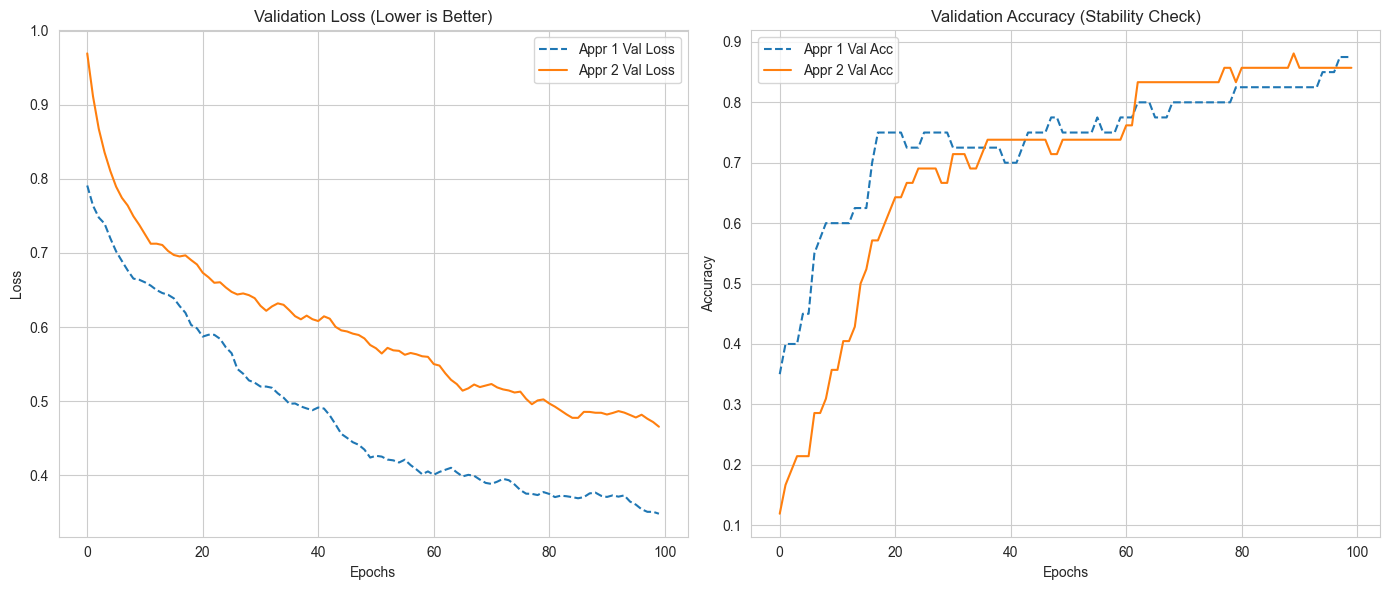

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
# Define paths to the datasets created in previous steps
FILE_PATH_1 = "S1_approach1/final_dataset_for_modeling.csv"
FILE_PATH_2 = "S1_approach2/final_dataset_approach2.csv"

# Model Configuration
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.001

# ---------------------------------------------------------
# 2. HELPER FUNCTION: BUILD & TRAIN MODEL
# ---------------------------------------------------------
def train_evaluate_model(file_path, approach_name):
    print(f"\n{'='*60}")
    print(f"PROCESSING: {approach_name}")
    print(f"Loading data from: {file_path}")
    print(f"{'='*60}")

    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return None, None, None, None

    # A. Load Data
    df = pd.read_csv(file_path)
    
    # Drop identification columns not used for learning
    if 'patient_id' in df.columns:
        df = df.drop(columns=['patient_id'])
    
    # Separate Features (X) and Target (y)
    X = df.drop(columns=['T2DM'])
    y = df['T2DM'].astype(int) # Ensure target is 0/1 integer

    print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
    print(f"Class Distribution:\n{y.value_counts()}")

    # B. Preprocessing
    # Neural Networks require scaled data (mean=0, std=1) for convergence
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split Train/Test (80/20)
    # Stratify is CRITICAL here to ensure both sets have same % of T2DM cases
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # C. Define Neural Network Architecture
    # Simple MLP: Input -> Hidden(16) -> Dropout -> Hidden(8) -> Output(1)
    model = Sequential([
        Dense(16, input_dim=X_train.shape[1], activation='relu'),
        Dropout(0.3),  # Increased dropout slightly to handle small data better
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification (0 or 1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # D. Train
    print("\nTraining Model...")
    # Calculate class weights to handle imbalance
    # (Giving more weight to the rare T2DM class)
    neg, pos = np.bincount(y_train)
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(f"Using Class Weights: {class_weight}")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight, # CRITICAL: This helps model pay attention to rare T2DM cases
        verbose=0 
    )

    # E. Evaluation
    # Get Probability predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate Metrics
    acc = model.evaluate(X_test, y_test, verbose=0)[1]
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_pred_prob)
    except:
        auc = 0.5

    print(f"\n📊 RESULTS for {approach_name}:")
    print(f"   Recall (Sensitivity): {recall*100:.2f}%  <-- MOST IMPORTANT")
    print(f"   F1-Score:             {f1*100:.2f}%")
    print(f"   Accuracy:             {acc*100:.2f}%")
    print(f"   AUC-ROC:              {auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return history, acc, recall, f1

# ---------------------------------------------------------
# 3. EXECUTE COMPARISON
# ---------------------------------------------------------

# Train Approach 1
history1, acc1, rec1, f1_1 = train_evaluate_model(FILE_PATH_1, "Approach 1 (Neighbors Imputation)")

# Train Approach 2
history2, acc2, rec2, f1_2 = train_evaluate_model(FILE_PATH_2, "Approach 2 (Alternative Imputation)")

# ---------------------------------------------------------
# 4. VISUALIZATION & COMPARISON
# ---------------------------------------------------------
if history1 and history2:
    print(f"\n{'='*60}")
    print("FINAL COMPARISON (Based on F1-Score & Recall)")
    print(f"{'='*60}")
    print(f"Appr 1 -> Recall: {rec1*100:.1f}% | F1: {f1_1*100:.1f}% | Acc: {acc1*100:.1f}%")
    print(f"Appr 2 -> Recall: {rec2*100:.1f}% | F1: {f1_2*100:.1f}% | Acc: {acc2*100:.1f}%")

    # Decide Winner based on F1-Score (Balanced)
    if f1_1 > f1_2:
        winner = "Approach 1"
    elif f1_2 > f1_1:
        winner = "Approach 2"
    else:
        winner = "Tie"
        
    print(f"\n🏆 Winner (based on F1-Score): {winner}")
    if rec1 > rec2:
        print(f"ℹ️ Note: Approach 1 was better at finding positive cases (Higher Recall).")
    elif rec2 > rec1:
        print(f"ℹ️ Note: Approach 2 was better at finding positive cases (Higher Recall).")

    # Plot Training History
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_loss'], label='Appr 1 Val Loss', linestyle='--')
    plt.plot(history2.history['val_loss'], label='Appr 2 Val Loss', linestyle='-')
    plt.title('Validation Loss (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Recall (Validation)
    # Note: Keras history records 'accuracy' by default. 
    # We plot Accuracy here as a proxy for learning curve stability.
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_accuracy'], label='Appr 1 Val Acc', linestyle='--')
    plt.plot(history2.history['val_accuracy'], label='Appr 2 Val Acc', linestyle='-')
    plt.title('Validation Accuracy (Stability Check)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


PROCESSING: Approach 1 (Neighbors)
Running 5-Fold Cross Validation...
✅ Done. Avg Recall: 35.00% | Avg F1: 38.00%

PROCESSING: Approach 2 (Alt Imputation)
Running 5-Fold Cross Validation...
✅ Done. Avg Recall: 35.00% | Avg F1: 33.33%

FINAL COMPARISON
Approach 1 -> Recall: 35.0% | F1: 38.0%
Approach 2 -> Recall: 35.0% | F1: 33.3%

📊 Plot saved to: comparison_plot.png


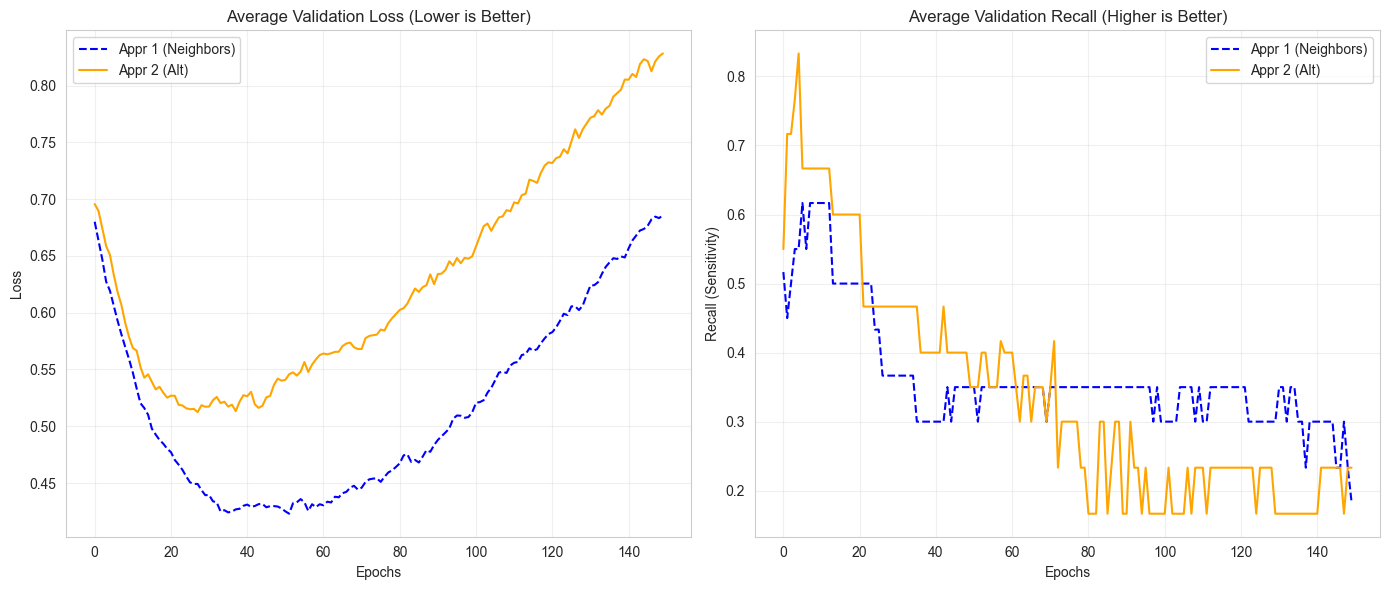

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
FILE_PATH_1 = "S1_approach1/final_dataset_for_modeling.csv"
FILE_PATH_2 = "S1_approach2/final_dataset_approach2.csv"
PLOT_OUTPUT = "comparison_plot.png"

EPOCHS = 150
BATCH_SIZE = 8
LEARNING_RATE = 0.0005

# ---------------------------------------------------------
# 2. HELPER: OVERSAMPLING
# ---------------------------------------------------------
def oversample_minority(X, y):
    """Manually duplicates the minority class (T2DM=1) to balance the dataset."""
    data = np.column_stack((X, y))
    negatives = data[data[:, -1] == 0]
    positives = data[data[:, -1] == 1]
    
    if len(positives) == 0: return X, y
        
    multiplier = len(negatives) // len(positives)
    positives_upsampled = np.tile(positives, (multiplier, 1))
    
    upsampled_data = np.vstack((negatives, positives_upsampled))
    # Set seed for reproducibility of the shuffle
    np.random.seed(42)
    np.random.shuffle(upsampled_data)
    
    return upsampled_data[:, :-1], upsampled_data[:, -1]

# ---------------------------------------------------------
# 3. HELPER: FIND OPTIMAL THRESHOLD
# ---------------------------------------------------------
def find_best_threshold(y_true, y_pred_prob):
    """Finds the decision threshold that maximizes the F1 Score."""
    best_thresh = 0.5
    best_f1 = 0.0
    # Scan thresholds from 10% to 90%
    thresholds = np.arange(0.1, 0.9, 0.05)
    for thresh in thresholds:
        y_pred = (y_pred_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1

# ---------------------------------------------------------
# 4. BUILD & TRAIN MODEL (With History Tracking)
# ---------------------------------------------------------
def train_evaluate_model(file_path, approach_name):
    print(f"\n{'='*60}")
    print(f"PROCESSING: {approach_name}")
    print(f"{'='*60}")

    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return None, 0, 0, 0

    # Load & Preprocess
    df = pd.read_csv(file_path)
    if 'patient_id' in df.columns: df = df.drop(columns=['patient_id'])
    X = df.drop(columns=['T2DM']).values
    y = df['T2DM'].astype(int).values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Store histories for averaging
    fold_histories = []
    fold_recalls = []
    fold_f1s = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("Running 5-Fold Cross Validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        X_train_res, y_train_res = oversample_minority(X_train, y_train)
        
        # Updated Model Definition (Fixes UserWarning)
        model = Sequential([
            Input(shape=(X_train.shape[1],)),  # Explicit Input Layer
            Dense(32, activation='relu'),
            Dropout(0.4),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        # Add Recall to metrics so we can plot it later
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy', 
                      metrics=['accuracy', Recall(name='recall')])
        
        history = model.fit(X_train_res, y_train_res, 
                            validation_data=(X_val, y_val),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        
        fold_histories.append(history.history)
        
        # Threshold Tuning & Metrics
        y_pred_prob = model.predict(X_val, verbose=0)
        best_thresh, best_f1 = find_best_threshold(y_val, y_pred_prob)
        y_pred = (y_pred_prob >= best_thresh).astype(int)
        
        rec = recall_score(y_val, y_pred, zero_division=0)
        fold_recalls.append(rec)
        fold_f1s.append(best_f1)

    # Average Metrics
    avg_recall = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)
    
    # Average History Curves across folds
    avg_history = {}
    # Metrics available: loss, accuracy, recall, val_loss, val_accuracy, val_recall
    metrics_to_avg = ['loss', 'val_loss', 'recall', 'val_recall']
    
    for metric in metrics_to_avg:
        if metric in fold_histories[0]:
            # Stack all folds (5, 150) and take mean across axis 0 -> (150,)
            avg_history[metric] = np.mean([h[metric] for h in fold_histories], axis=0)

    print(f"✅ Done. Avg Recall: {avg_recall*100:.2f}% | Avg F1: {avg_f1*100:.2f}%")
    return avg_history, 0, avg_recall, avg_f1

# ---------------------------------------------------------
# 5. EXECUTE & PLOT
# ---------------------------------------------------------
hist1, _, rec1, f1_1 = train_evaluate_model(FILE_PATH_1, "Approach 1 (Neighbors)")
hist2, _, rec2, f1_2 = train_evaluate_model(FILE_PATH_2, "Approach 2 (Alt Imputation)")

print(f"\n{'='*60}")
print("FINAL COMPARISON")
print(f"{'='*60}")
print(f"Approach 1 -> Recall: {rec1*100:.1f}% | F1: {f1_1*100:.1f}%")
print(f"Approach 2 -> Recall: {rec2*100:.1f}% | F1: {f1_2*100:.1f}%")

if hist1 and hist2:
    plt.figure(figsize=(14, 6))

    # Plot Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist1['val_loss'], label='Appr 1 (Neighbors)', linestyle='--', color='blue')
    plt.plot(hist2['val_loss'], label='Appr 2 (Alt)', linestyle='-', color='orange')
    plt.title('Average Validation Loss (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Validation Recall (Sensitivity)
    # Note: This uses the default threshold (0.5) for the curve, 
    # while the printed metrics use the tuned threshold.
    plt.subplot(1, 2, 2)
    plt.plot(hist1['val_recall'], label='Appr 1 (Neighbors)', linestyle='--', color='blue')
    plt.plot(hist2['val_recall'], label='Appr 2 (Alt)', linestyle='-', color='orange')
    plt.title('Average Validation Recall (Higher is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Recall (Sensitivity)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_OUTPUT)
    print(f"\n📊 Plot saved to: {PLOT_OUTPUT}")
    plt.show()


PROCESSING: Approach 1
Running 5-Fold CV with Oversampling...
✅ Results for Approach 1:
   Avg Recall: 43.33%
   Avg F1:     35.35%
   Mean AUC:   0.6754

PROCESSING: Approach 2
Running 5-Fold CV with Oversampling...
✅ Results for Approach 2:
   Avg Recall: 53.33%
   Avg F1:     35.29%
   Mean AUC:   0.6556

GENERATING PLOTS
📊 Plot saved to: rf_comparison_plot.png


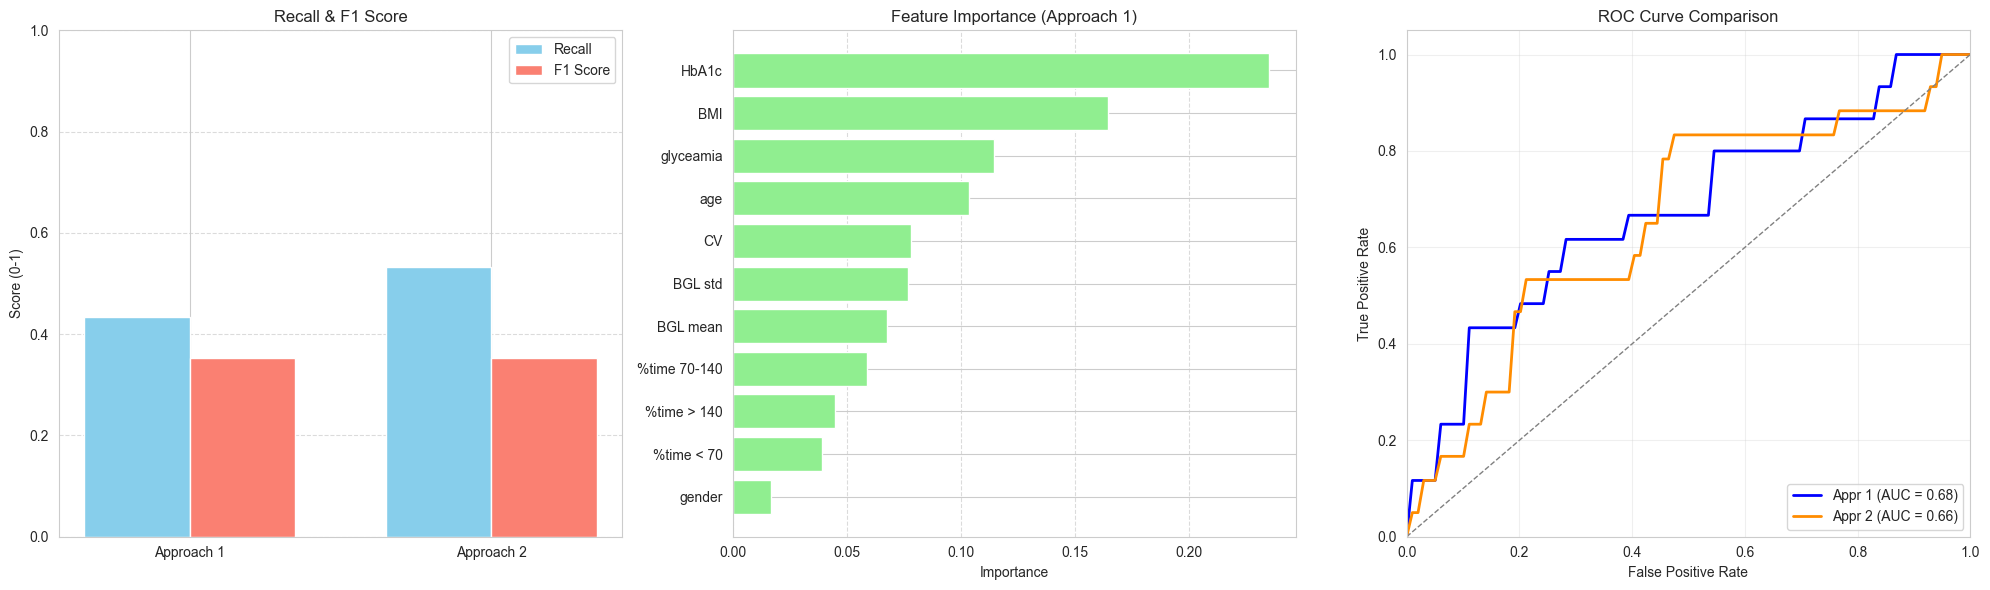

In [29]:
# RANDOM FOREST
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
FILE_PATH_1 = "S1_approach1/final_dataset_for_modeling.csv"
FILE_PATH_2 = "S1_approach2/final_dataset_approach2.csv"
PLOT_FILE = "rf_comparison_plot.png"

# ---------------------------------------------------------
# 2. HELPERS
# ---------------------------------------------------------
def oversample_minority(X, y):
    """Manually duplicates the minority class to balance the dataset."""
    data = np.column_stack((X, y))
    negatives = data[data[:, -1] == 0]
    positives = data[data[:, -1] == 1]
    
    if len(positives) == 0: return X, y
        
    multiplier = len(negatives) // len(positives)
    positives_upsampled = np.tile(positives, (multiplier, 1))
    
    upsampled_data = np.vstack((negatives, positives_upsampled))
    np.random.seed(42)
    np.random.shuffle(upsampled_data)
    
    return upsampled_data[:, :-1], upsampled_data[:, -1]

def find_best_threshold(y_true, y_pred_prob):
    """Finds the threshold that maximizes F1-Score."""
    best_thresh = 0.5
    best_f1 = 0.0
    for thresh in np.arange(0.1, 0.6, 0.05):
        y_pred = (y_pred_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1

# ---------------------------------------------------------
# 3. EVALUATE RANDOM FOREST (Now with ROC)
# ---------------------------------------------------------
def evaluate_rf(file_path, approach_name):
    print(f"\n{'='*60}")
    print(f"PROCESSING: {approach_name}")
    print(f"{'='*60}")

    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return 0, 0, None, [], None, None, 0

    # Load Data
    df = pd.read_csv(file_path)
    if 'patient_id' in df.columns: df = df.drop(columns=['patient_id'])
    
    feature_names = df.drop(columns=['T2DM']).columns.tolist()
    X = df.drop(columns=['T2DM']).values
    y = df['T2DM'].astype(int).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_recalls = []
    fold_f1s = []
    feature_importances = []
    
    # ROC Interpolation variables
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    print("Running 5-Fold CV with Oversampling...")

    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # 1. Oversample
        X_train_res, y_train_res = oversample_minority(X_train, y_train)

        # 2. Train RF
        clf = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced'
        )
        
        clf.fit(X_train_res, y_train_res)
        feature_importances.append(clf.feature_importances_)
        
        # 3. Predict & Tune
        y_pred_prob = clf.predict_proba(X_val)[:, 1]
        best_thresh, best_f1 = find_best_threshold(y_val, y_pred_prob)
        y_pred = (y_pred_prob >= best_thresh).astype(int)
        
        fold_recalls.append(recall_score(y_val, y_pred, zero_division=0))
        fold_f1s.append(best_f1)
        
        # 4. ROC Curve Calculation for this fold
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    # Average Metrics
    avg_recall = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)
    avg_feat_imp = np.mean(feature_importances, axis=0)
    
    # Average ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    print(f"✅ Results for {approach_name}:")
    print(f"   Avg Recall: {avg_recall*100:.2f}%")
    print(f"   Avg F1:     {avg_f1*100:.2f}%")
    print(f"   Mean AUC:   {mean_auc:.4f}")
    
    return avg_recall, avg_f1, avg_feat_imp, feature_names, mean_fpr, mean_tpr, mean_auc

# ---------------------------------------------------------
# 4. EXECUTE
# ---------------------------------------------------------
rec1, f1_1, imp1, feats1, fpr1, tpr1, auc1 = evaluate_rf(FILE_PATH_1, "Approach 1")
rec2, f1_2, imp2, feats2, fpr2, tpr2, auc2 = evaluate_rf(FILE_PATH_2, "Approach 2")

# ---------------------------------------------------------
# 5. FINAL COMPARISON & PLOTTING
# ---------------------------------------------------------
print(f"\n{'='*60}")
print("GENERATING PLOTS")
print(f"{'='*60}")

if f1_1 > f1_2:
    winner_imp, winner_feats, winner_name = imp1, feats1, "Approach 1"
else:
    winner_imp, winner_feats, winner_name = imp2, feats2, "Approach 2"

plt.figure(figsize=(20, 6)) # Increased width for 3 subplots

# Plot 1: Metrics Comparison
plt.subplot(1, 3, 1)
labels = ['Approach 1', 'Approach 2']
recall_vals = [rec1, rec2]
f1_vals = [f1_1, f1_2]
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, recall_vals, width, label='Recall', color='skyblue')
plt.bar(x + width/2, f1_vals, width, label='F1 Score', color='salmon')
plt.ylabel('Score (0-1)')
plt.title('Recall & F1 Score')
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Feature Importance
if winner_imp is not None:
    plt.subplot(1, 3, 2)
    indices = np.argsort(winner_imp)
    plt.title(f'Feature Importance ({winner_name})')
    plt.barh(range(len(indices)), winner_imp[indices], color='lightgreen', align='center')
    plt.yticks(range(len(indices)), [winner_feats[i] for i in indices])
    plt.xlabel('Importance')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

# Plot 3: ROC Curve Comparison
plt.subplot(1, 3, 3)
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'Appr 1 (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'Appr 2 (AUC = {auc2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_FILE)
print(f"📊 Plot saved to: {PLOT_FILE}")
plt.show()